# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import pathlib
import PIL
import os
import time
from glob import glob

from PIL import Image as PImage
from PIL import ImageFilter
import random
import math

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


AUTOTUNE = tf.data.AUTOTUNE


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Creating the data pipeline


Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

first parameters for loading

In [4]:
batch_size = 64 
img_height = 64
img_width = 64
epochs = 20

validation = 0.2

data_dir = 'Data/characters/'

Split the data into 80% training and 20% testing

In [5]:
from glob import glob
import random

def make_dataset(path, batch_size, character):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [img_height, img_width])
    return image

  def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    #ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  dataset_size = len(filenames)
  random.shuffle(filenames)
  labels = [classes.index(name.split(os.path.sep)[-2]) for name in filenames]
  
  #print(f'Labels: {len(labels)}, Files: {len(filenames)}')

  print(filenames[:10])

  labels, filenames = zip(*((x, y) for x, y in zip(labels, filenames) if x == classes.index(character) or random.random() < 0.005))
  labels = list(labels)
  filenames = list(filenames)

  print(f'Labels: {len(labels)}, Files: {len(filenames)}')


  labels = [1 if x == classes.index(character) else 0 for x in labels]


  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds, ['Not', character], len(labels)

In [6]:
dataset, class_names, dataset_size = make_dataset(data_dir, batch_size, '傷'')

val_size = int(validation * dataset_size / batch_size)

print(f'Size: {dataset_size}, val: {val_size * batch_size}')


val_ds = dataset.take(val_size)

train_ds = dataset.skip(val_size)

train_size = dataset_size - val_size

#train_ds = train_ds.map()

# PRINT VALIDATION HERE

['Data/characters\\掘\\掘_192.png', 'Data/characters\\等\\等_182.png', 'Data/characters\\首\\首_084.png', 'Data/characters\\沌\\沌_161.png', 'Data/characters\\鮫\\鮫_070.png', 'Data/characters\\炊\\炊_170.png', 'Data/characters\\蛇\\蛇_061.png', 'Data/characters\\兆\\兆_146.png', 'Data/characters\\源\\源_195.png', 'Data/characters\\率\\率_005.png']
['Data/characters\\挺\\挺_128.png', 'Data/characters\\党\\党_064.png', 'Data/characters\\艶\\艶_059.png', 'Data/characters\\牧\\牧_149.png', 'Data/characters\\快\\快_071.png', 'Data/characters\\紛\\紛_006.png', 'Data/characters\\禅\\禅_019.png', 'Data/characters\\孔\\孔_189.png', 'Data/characters\\旗\\旗_075.png', 'Data/characters\\李\\李_065.png']
Labels: 2672, Files: 2672
Size: 2672, val: 512


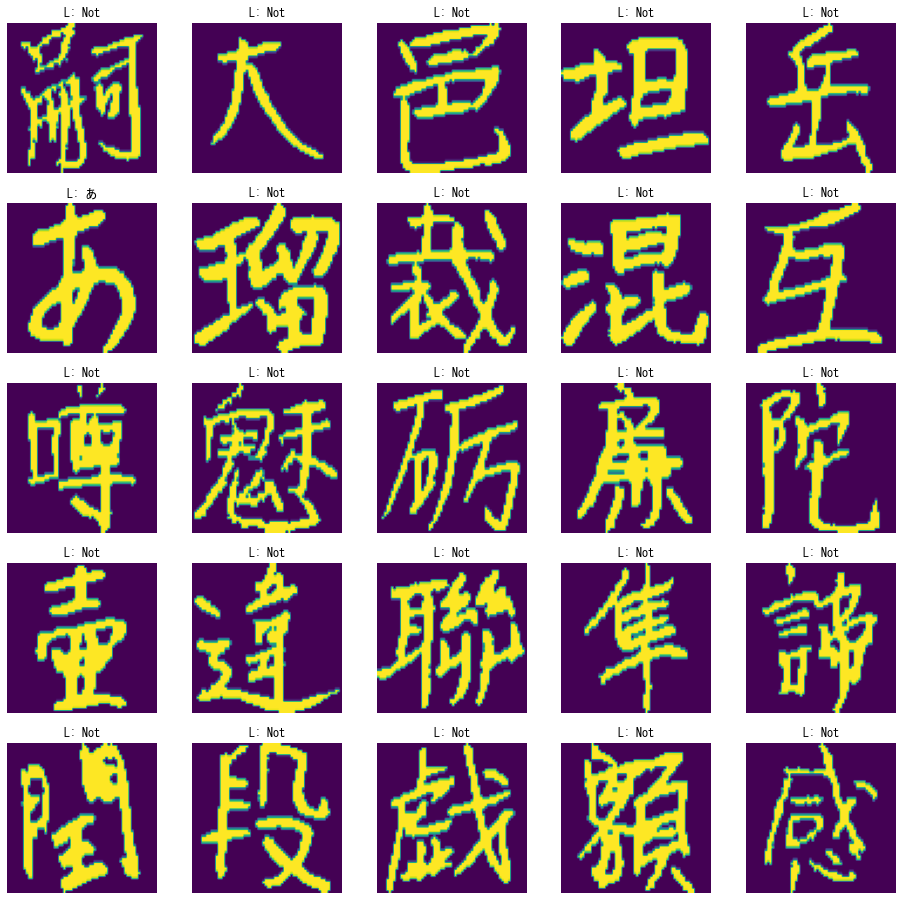

In [7]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(16, 16))
i = 0

while i < 25:
    ax = plt.subplot(5, 5, i + 1)
    #plt.imshow(aug[i].numpy().astype("uint8"))
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'L: {class_names[label]}')
    plt.axis("off")
    i += 1


# Train the model

## Set up model

structures from [2]

In [8]:
from models import *

model = get_BinaryClassifier(len(class_names))

#can't have here with the resize layer
#model.summary()

In [9]:
model_dir = 'D:\\MachineLearning\\models'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.ckpt")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [10]:
sched = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 5 * train_size ,
    decay_rate = 0.9,
    staircase = True,
)


optimizer = tf.keras.optimizers.Adam(learning_rate=sched,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-8,
                                #clipvalue=1,
                                )
                                
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [11]:
#model = tf.keras.models.load_model(os.path.join(model_dir, "tf", "trained_model"))
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-30-0.20.hdf5"))

In [12]:
history = model.fit(
    x=train_ds,
    epochs=epochs,
    initial_epoch=0,
    validation_data=val_ds,
    callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=4)

Epoch 1/20
34/34 [==============================] - 10s 130ms/step - loss: 0.4213 - accuracy: 0.8708 - val_loss: 0.2660 - val_accuracy: 0.9316

Epoch 00001: val_accuracy improved from -inf to 0.93164, saving model to D:\MachineLearning\models\tf\checkpoints\weights-improvement-01-0.93.ckpt
INFO:tensorflow:Assets written to: D:\MachineLearning\models\tf\checkpoints\weights-improvement-01-0.93.ckpt\assets
Epoch 2/20
34/34 [==============================] - 1s 21ms/step - loss: 0.2700 - accuracy: 0.9206 - val_loss: 0.3227 - val_accuracy: 0.9180

Epoch 00002: val_accuracy did not improve from 0.93164
Epoch 3/20
34/34 [==============================] - 1s 20ms/step - loss: 0.2325 - accuracy: 0.9272 - val_loss: 0.1326 - val_accuracy: 0.9160

Epoch 00003: val_accuracy did not improve from 0.93164
Epoch 4/20
34/34 [==============================] - 1s 20ms/step - loss: 0.1465 - accuracy: 0.9304 - val_loss: 0.0524 - val_accuracy: 0.9766

Epoch 00004: val_accuracy improved from 0.93164 to 0.9765

8/8 - 0s - loss: 0.0068 - accuracy: 0.9980
0.998046875


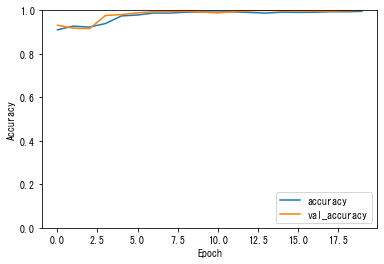

In [13]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [14]:
#model.save(os.path.join(model_dir, "tf", "trained_model"))

In [15]:
model.summary()

Model: "M9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 1)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 64, 64, 1)         0         
_________________________________________________________________
random_translation (RandomTr (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0        

In [16]:
test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

8/8 - 0s - loss: 0.0073 - accuracy: 0.9980


In [18]:
print(model.predict_classes(val_ds))

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

In [19]:
print(model.predict(val_ds))

[[  5.57   -5.734]
 [  7.137  -7.39 ]
 [  7.043  -7.285]
 ...
 [  9.766 -10.13 ]
 [  5.504  -5.74 ]
 [  9.54   -9.914]]
